In [2]:
!pip install pandas_ta



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=64a452c2f84607924dbcfd895d44454a580541286887b9fda2ce2dcd43191ff2
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt



In [5]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [6]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


In [7]:
RSI = ta.rsi(close,10,scalar=1)
AROON = ta.aroon(high,low,14,scalar = 1)
AROON_UP = AROON['AROOND_14']
AROON_DOWN = AROON['AROONU_14']
CCI = ta.cci(high,low,close,10)
CCI = CCI.multiply(.001)
CCI = CCI.add(.5)
RVI = ta.rvi(close,high,low,10,scalar=1)
CHANGE = get_relative_change(close,"Change")
SMA = ta.sma(close,20,offset=-10)
INDICATORS = pd.concat([close,RSI,AROON_UP,AROON_DOWN,CCI,RVI,SMA],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()

close_df = INDICATORS.pop('AC')
SMA_df = INDICATORS.pop('SMA_20')
INDICATORS.pop('index')

INDICATORS = INDICATORS.to_numpy()
change = close_df.to_numpy()
change_dev = change.std()
change = change/change_dev
np_close = close_df.to_numpy()
np_sma = SMA_df.to_numpy()

target = np_close-np_sma
target = target/np.std(target)
np.set_printoptions(suppress=True)
print(target)

[-0.97452456  0.07262919 -0.48701355 ... -0.34399374 -0.83050983
 -0.1544614 ]


(1.2, 1.4)

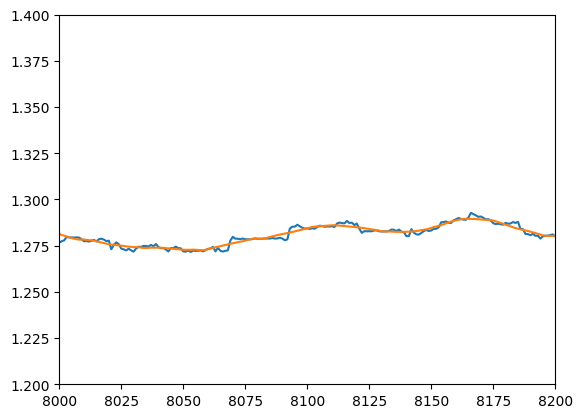

In [8]:
plt.plot(close)
plt.plot(SMA)
plt.xlim(8000,8200)
plt.ylim(1.2,1.4)

(8000.0, 8200.0)

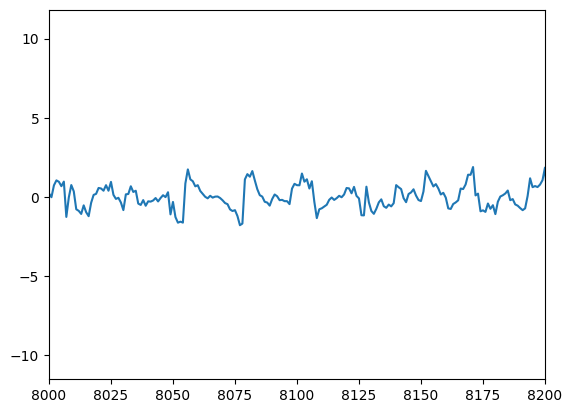

In [9]:
plt.plot(target)
plt.xlim(8000,8200)

In [10]:
print(INDICATORS)

[[0.35318903 1.         0.71428571 0.33561297 0.58164603]
 [0.51573014 0.92857143 0.64285714 0.39914828 0.67263931]
 [0.43910193 0.85714286 0.57142857 0.39308176 0.51839906]
 ...
 [0.51519319 0.         0.85714286 0.48350417 0.39667975]
 [0.45588483 0.         0.78571429 0.4164116  0.33706913]
 [0.55693828 0.         0.71428571 0.47257688 0.43980838]]


(5400.0, 5500.0)

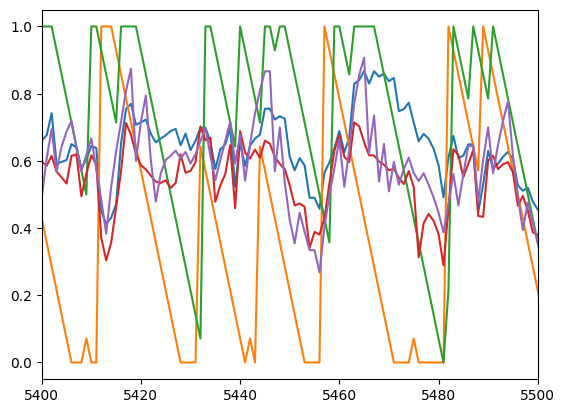

In [11]:
plt.plot(INDICATORS)
plt.xlim(5400,5500)
#print(INDICATORS)

In [12]:
def my_dist(params):
    return tfp.distributions.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))

inputs = tf.keras.Input(shape=(5,))

hidden1 = tf.keras.layers.Dense(30,activation="LeakyReLU")(inputs)
norm1 = tf.keras.layers.LayerNormalization()(hidden1)
dropout1 = tf.keras.layers.Dropout(.2)(norm1)
hidden2 = tf.keras.layers.Dense(50,activation="LeakyReLU")(dropout1)
norm1 = tf.keras.layers.LayerNormalization()(hidden1)
dropout2 = tf.keras.layers.Dropout(.2)(hidden2)
hidden3 = tf.keras.layers.Dense(2, activation="linear")(dropout2)

dist = tfp.layers.DistributionLambda(my_dist)(hidden3)

model = tf.keras.Model(inputs=inputs, outputs=dist)

In [13]:
reg = keras.regularizers.L2()
def dense(num_neurons):
  return layers.Dense(num_neurons, activation="LeakyReLU",kernel_regularizer=reg)

def normalization():
  return layers.LayerNormalization()

def drop(rate):
  return layers.Dropout(rate)




model = keras.Sequential()
model.add(dense(6))
#model.add(normalization())
model.add(layers.Dense(2, activation="linear"))
model.add(tfp.layers.DistributionLambda(my_dist))

In [14]:
def NLL(y_true, distr):
    return -distr.log_prob(y_true)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=NLL)

In [15]:
model.fit(INDICATORS, target, epochs=50)

Epoch 1/50
2909/2909 [==============================] - 8s 2ms/step - loss: 1.2851
Epoch 2/50
2909/2909 [==============================] - 3s 1ms/step - loss: 1.2652
Epoch 3/50
2909/2909 [==============================] - 3s 1ms/step - loss: 1.2621
Epoch 4/50
2909/2909 [==============================] - 4s 1ms/step - loss: 1.2605
Epoch 5/50
2909/2909 [==============================] - 3s 1ms/step - loss: 1.2602
Epoch 6/50
2909/2909 [==============================] - 3s 1ms/step - loss: 1.2600
Epoch 7/50
2909/2909 [==============================] - 3s 995us/step - loss: 1.2594
Epoch 8/50
2909/2909 [==============================] - 4s 1ms/step - loss: 1.2557
Epoch 9/50
2909/2909 [==============================] - 3s 989us/step - loss: 1.2553
Epoch 10/50
2909/2909 [==============================] - 3s 1ms/step - loss: 1.2542
Epoch 11/50
2909/2909 [==============================] - 3s 1ms/step - loss: 1.2522
Epoch 12/50
2909/2909 [==============================] - 4s 1ms/step - loss: 1.25

In [19]:
def is_numpy_array(obj):
       return type(obj) is np.ndarray

In [21]:

activation = ["AF.leaky_relu","AF.linear", "AF.leaky_relu","AF.linear", "AF.linear","AF.linear","AF.linear","AF.gelu","AF.linear"]
network = model.get_weights()
# Create an array of integers from 0 to 25 representing ASCII values of lowercase letters
ascii_values = np.arange(97, 123)

# Convert the ASCII values to characters using the 'chr' function
characters = np.char.add('', np.char.mod('%c', ascii_values))

# Create an empty array to store the selected arrays
bias = np.empty_like(network[1::2])  # Create an empty array with the same shape as the selected arrays
# Create an empty array to store the selected arrays
weight = np.empty_like(network[::2])  # Create an empty array with the same shape as the selected arrays

#Iterate over the main array and select every second array
for i, arr in enumerate(network[1::2]):
    bias[i] = arr

for i, arr in enumerate(network[::2]):
    weight[i] = arr



for lay_num, layer in enumerate(weight):
  for neu_num, neuron in enumerate(np.transpose(layer)):
    if not is_numpy_array(neuron):
      neuron_makeup = str(characters[lay_num+1]) + str(neu_num) + " = ("
      neuron_makeup += str(neuron) + " * " + characters[lay_num]  + str(neu_num) + " + " +  str(bias[lay_num][neu_num]) + ")"

    else:
      neuron_makeup = str(characters[lay_num+1]) + str(neu_num) + " = " + activation[lay_num] + "("
      for mul_num, mult in enumerate(neuron):
          neuron_makeup += str(mult) + " * " +characters[lay_num] + str(mul_num) + " + "
      neuron_makeup += str(bias[lay_num][neu_num]) + ")"
    np.set_printoptions(suppress=True)
    print(neuron_makeup)

b0 = AF.leaky_relu(0.008766834 * a0 + 3.4021214e-05 * a1 + 0.013736625 * a2 + 0.005331221 * a3 + 0.004167209 * a4 + -0.018803151)
b1 = AF.leaky_relu(0.018368088 * a0 + -0.0069081113 * a1 + 0.010032756 * a2 + 0.012692612 * a3 + 0.008130163 * a4 + -0.024340784)
b2 = AF.leaky_relu(0.5409183 * a0 + 0.114762686 * a1 + 0.1096057 * a2 + 0.5056335 * a3 + 0.13092338 * a4 + -0.7338321)
b3 = AF.leaky_relu(0.053704478 * a0 + 0.017093627 * a1 + 0.056080155 * a2 + 0.04066344 * a3 + 0.036780488 * a4 + -0.017086364)
b4 = AF.leaky_relu(-0.42202863 * a0 + 0.16593598 * a1 + 0.114696674 * a2 + -0.47374505 * a3 + -0.15806484 * a4 + 0.4096496)
b5 = AF.leaky_relu(0.0060235895 * a0 + 0.0058877263 * a1 + 0.0054669576 * a2 + 0.00595997 * a3 + 0.002113668 * a4 + -0.0458771)
c0 = AF.linear(-0.015986502 * b0 + -0.022606988 * b1 + 3.076464 * b2 + -0.050708737 * b3 + -3.1866133 * b4 + -0.015306987 * b5 + -0.028674532)
c1 = AF.linear(0.16885589 * b0 + 0.12373014 * b1 + 35.21865 * b2 + 0.38642922 * b3 + 30.419127 * b4

In [18]:
network = model.get_weights()
print(network)

[array([[ 0.00876683,  0.01836809,  0.5409183 ,  0.05370448, -0.42202863,
         0.00602359],
       [ 0.00003402, -0.00690811,  0.11476269,  0.01709363,  0.16593598,
         0.00588773],
       [ 0.01373663,  0.01003276,  0.1096057 ,  0.05608016,  0.11469667,
         0.00546696],
       [ 0.00533122,  0.01269261,  0.5056335 ,  0.04066344, -0.47374505,
         0.00595997],
       [ 0.00416721,  0.00813016,  0.13092338,  0.03678049, -0.15806484,
         0.00211367]], dtype=float32), array([-0.01880315, -0.02434078, -0.7338321 , -0.01708636,  0.4096496 ,
       -0.0458771 ], dtype=float32), array([[-0.0159865 ,  0.16885589],
       [-0.02260699,  0.12373014],
       [ 3.076464  , 35.21865   ],
       [-0.05070874,  0.38642922],
       [-3.1866133 , 30.419127  ],
       [-0.01530699,  0.28946424]], dtype=float32), array([-0.02867453,  3.9451575 ], dtype=float32)]
